Notes: 
 - consistent colors for all methods
 - bold or somehow distinguish the `random` and `oracle` methods

In [291]:
library(tidyverse)
library(RColorBrewer)
library(stringr)
library(magrittr)
library(gridExtra)
library(latex2exp)
library(xtable)

plotsize = function (x,y) options(repr.plot.width=x, repr.plot.height=y)

Warning message:
: package ‘latex2exp’ was built under R version 3.2.3

In [267]:
method_renames = c(
random = "Random",
mse = "$\\widehat{\\mu\\text{-risk}}$",
wmse = "$\\widehat{\\mu\\text{-risk}}_{IPTW}$",
ip_value = "$\\hat v_{IPTW}$",
dml_value = "$\\hat v_{DR}$",
match_mse = "$\\widehat{\\tau\\text{-risk}}_{match}$",
trans_mse = "$\\widehat{\\tau\\text{-risk}}_{IPTW}$",
r_objective = "$\\widehat{\\tau\\text{-risk}}_{R}$")

Derived from some garbage....

In [393]:
new_labels = c(
    mse = expression(paste("", "", widehat(paste("", mu, , , , , paste("-risk"), , )), "")),
    wmse = expression(paste("", "", 
        widehat(paste("", mu, , , , , paste("-risk"), , )), phantom()[{
            paste("", "IPTW")
        }], "")),
    ip_value = expression(paste("", "", -hat(v), , phantom()[{
            paste("IPTW")
        }], "")),
    dml_value = expression(paste("", "", -hat(v), , phantom()[{
            paste("DR")
        }], "")),
    match_mse = expression(paste("", 
        "", widehat(paste("", tau, , , , , paste("-risk"), , 
            )), phantom()[{
            paste("", "match")
        }], "")),
    trans_mse = expression(paste("", 
        "", widehat(paste("", tau, , , , , paste("-risk"), , 
            )), phantom()[{
            paste("", "IPTW")
        }], "")),
    r_objective = expression(paste("", "", 
        widehat(paste("", tau, , , , , paste("-risk"), , )), 
        phantom()[{
            paste("", "R")
        }], ""))
    )

In [419]:
results = read_csv("data/experimental_results_1_100.csv") %>%
    select(dgp, replicate, model, value, tmse, names(method_renames))
results %>% select(replicate, dgp) %>% table

Parsed with column specification:
cols(
  model = col_character(),
  mse = col_double(),
  wmse = col_double(),
  r_objective = col_double(),
  match_mse = col_double(),
  trans_mse = col_double(),
  ip_value = col_double(),
  dml_value = col_double(),
  random = col_integer(),
  tmse = col_double(),
  value = col_double(),
  replicate = col_integer(),
  dgp = col_integer()
)


         dgp
replicate   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
      1   201 201 201 201 201 201 201 201 201 201 201 201 201 201 201 201
      2   201 201 201 201 201 201 201 201 201 201 201 201 201 201 201 201
      3   201 201 201 201 201 201 201 201 201 201 201 201 201 201 201 201
      4   201 201 201 201 201 201 201 201 201 201 201 201 201 201 201 201
      5   201 201 201 201 201 201 201 201 201 201 201 201 201 201 201 201
      6   201 201 201 201 201 201 201 201 201 201 201 201 201 201 201 201
      7   201 201 201 201 201 201 201 201 201 201 201 201 201 201 201 201
      8   201 201 201 201 201 201 201 201 201 201 201 201 201 201 201 201
      9   201 201 201 201 201 201 201 201 201 201 201 201 201 201 201 201
      10  201 201 201 201 201 201 201 201 201 201 201 201 201 201 201 201
      11  201 201 201 201 201 201 201 201 201 201 201 201 201 201 201 201
      12  201 201 201 201 201 201 201 201 201 201 201 201 201 201 201 201
      13  201 201 201 201

In [380]:
plotsize(20,10)

averaged_results = results %>%
    group_by(dgp, model) %>%
    select(-replicate) %>%
    summarize_all(mean)

test_metrics = averaged_results %>% select(dgp, model, value, tmse)
val_metrics = averaged_results %>% select(-value, -tmse)

ttm = test_metrics %>% gather(tt_metric, tt_figure, -model, -dgp)
vm = val_metrics %>% gather(v_metric, v_figure, -model, -dgp)

plots = inner_join(ttm, vm, by=c("model","dgp")) %>%
    separate(model, c("learner", "model"), sep="\\$") %>%
    separate(model, c("method", "params"), sep="@") %>%
split(.$dgp) %>% imap(function(plot_data, dgp_id) {
    plot_data %>%
    ggplot(aes(x=tt_figure, y=v_figure, color=method, shape=learner)) +
    geom_point() +
    facet_grid(v_metric~tt_metric, scales="free") +
    ggtitle(str_c('DGP: ', dgp_id)) + 
    theme(legend.position="none")
})
# grid.arrange(grobs=plots, nrow=2)

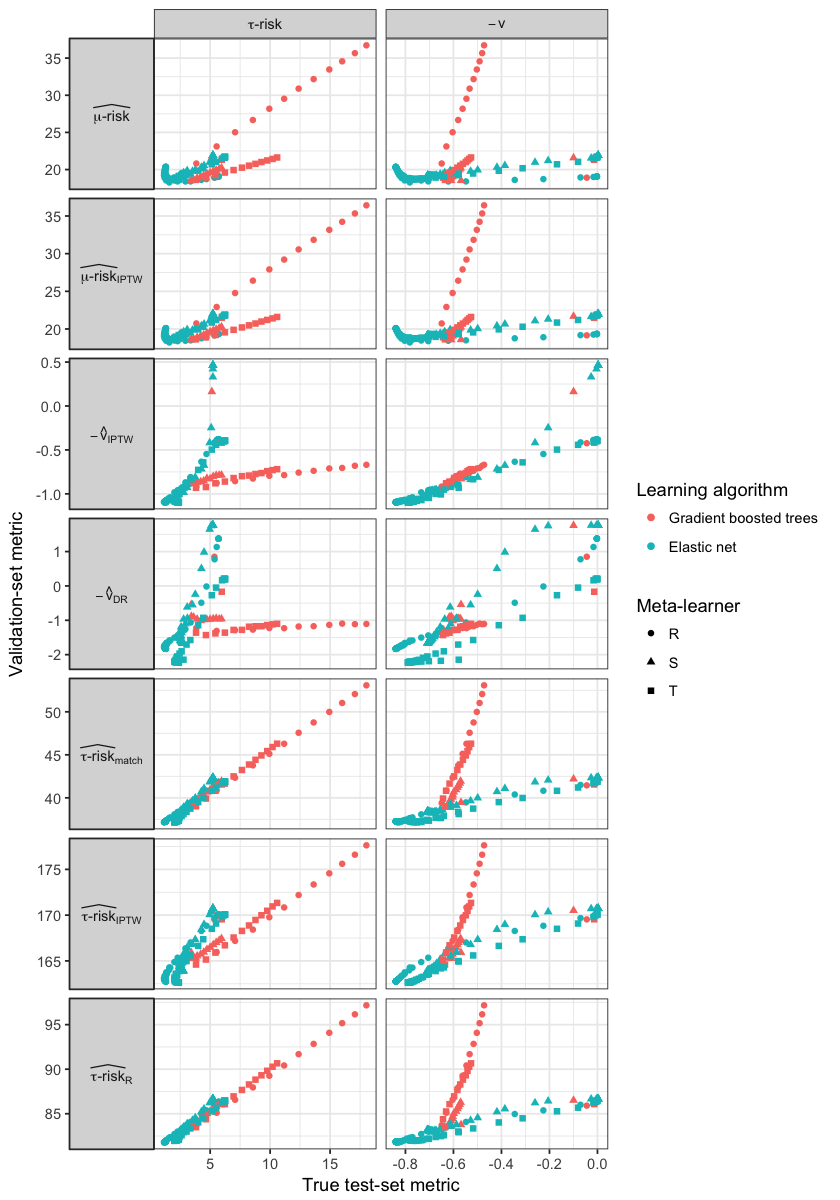

In [420]:
test_names = c(
    tmse = expression(paste(tau, "-risk")), 
    value=expression(-v))

algorithms = c(
    gbm = "Gradient boosted trees",
    glmnet = "Elastic net")

plotsize(7,10)

test_metrics = averaged_results %>% 
    select(dgp, model, value, tmse) %>%
    mutate(value = -value)
val_metrics = averaged_results %>% select(-value, -tmse) %>%
    mutate(ip_value = -ip_value, dml_value = -dml_value)

ttm = test_metrics %>% gather(tt_metric, tt_figure, -model, -dgp)
vm = val_metrics %>% gather(v_metric, v_figure, -model, -dgp)

inner_join(ttm, vm, by=c("model","dgp")) %>%
    separate(model, c("learner", "model"), sep="\\$") %>%
    separate(model, c("method", "params"), sep="@") %>%
    filter(dgp==16, v_metric!="random") %>%
    mutate(v_metric = factor(v_metric, levels=names(new_labels), labels=new_labels)) %>%
    mutate(tt_metric = factor(tt_metric, levels=names(test_names), labels=test_names)) %>%
    mutate(method = factor(method, levels=names(algorithms), labels=algorithms)) %>%
ggplot(aes(x=tt_figure, y=v_figure, color=method, shape=learner)) +
    geom_point() +
    facet_grid(v_metric~tt_metric, switch="y", scales="free", labeller = label_parsed) +
#     scale_y_discrete(labels=method_renames) +
    xlab("True test-set metric") + 
    ylab("Validation-set metric") + 
    theme_bw() + 
    theme(strip.text.y = element_text(angle = 180)) + 
    labs(color="Learning algorithm", shape="Meta-learner")

ggsave("paper/figures/detailed_results_sim16.png", device="png", height=10, width=7)

In [421]:
best_val = results %>%
    mutate(
        ip_value = -ip_value, 
        dml_value = -dml_value) %>%
    gather(validation_metric, estimate, -value, -tmse, -model, -dgp, -replicate) %>%
    group_by(dgp, replicate, validation_metric) %>%
    filter(estimate == min(estimate)) %>%
    sample_n(1) %>% ungroup() 
#     filter(validation_metric != "qini")

best_val_mean = best_val %>%
    ungroup() %>% group_by(dgp, validation_metric) %>%
    summarize(
        value_mean = mean(value), 
        value_se=sd(value)/n(), 
        tmse_mean = mean(tmse),
        tmse_se=sd(tmse)/n()) 

best_val_overall_mean = best_val %>%
    ungroup() %>% group_by(validation_metric) %>%
    summarize(
        value_mean = mean(value), 
        value_se=sd(value)/n(), 
        tmse_mean = mean(tmse),
        tmse_se=sd(tmse)/n())

In [422]:
best_val_methods = best_val %>% 
    separate(model, c("learner", "model"), sep="\\$") %>%
    separate(model, c("method", "params"), sep="@") %>%
    group_by(dgp, validation_metric, learner, method) %>%
    summarize(count=n())

In [423]:
best_true_methods = results %>%
    select(value, tmse, model, dgp, replicate) %>%
    mutate(value=-value) %>%
    gather(test_metric, estimate, -model, -dgp, -replicate) %>%
    group_by(dgp, replicate, test_metric) %>%
    filter(estimate == min(estimate)) %>%
    sample_n(1) %>% ungroup()  %>% 
    separate(model, c("learner", "model"), sep="\\$") %>%
    separate(model, c("method", "params"), sep="@") %>%
    group_by(dgp, test_metric, learner, method) %>%
    summarize(count=n())

In [425]:
make_table = function(df, test_metric, opt) {
    test_metric = enquo(test_metric)
    df %>% ungroup() %>% group_by(dgp, validation_metric) %>%
    summarize(
        mean_metric = mean(!! test_metric), 
        sd_mean_metric=sd(!! test_metric)/n())  %>% 
#     mutate(test_metric_col = ifelse(mean_metric != opt(mean_metric),
#         sprintf("%0.3f (%0.2f)", mean_metric, sd_mean_metric),
#         sprintf("\\bfseries{%0.3f} (%0.2f)", mean_metric, sd_mean_metric))) %>% 
    mutate(test_metric_col = ifelse(mean_metric != opt(mean_metric),
        sprintf("%0.3f", mean_metric, sd_mean_metric),
        sprintf("\\bfseries{%0.3f}", mean_metric, sd_mean_metric))) %>% 
    select(dgp, test_metric_col, validation_metric) %>%
    spread(dgp, test_metric_col) %>%
    mutate(metric = factor(validation_metric, levels=names(method_renames), labels=method_renames)) %>%
    arrange(metric) %>%
    select(-validation_metric) %>%
    select(metric, everything()) %>%
    xtable %>% 
    print.xtable(
        type="latex", 
        sanitize.text.function = function(x) x,
        include.rownames=FALSE)
}

best_val %>% split(.$dgp>=9) %>% map(~make_table(., tmse, min))

% latex table generated in R 3.2.2 by xtable 1.7-4 package
% Wed May  9 22:18:06 2018
\begin{table}[ht]
\centering
\begin{tabular}{lllllllll}
  \hline
metric & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\ 
  \hline
Random & 0.102 & 2.684 & 2.223 & 1.718 & 1.233 & 2.845 & 5.859 & 2.677 \\ 
  $\widehat{\mu\text{-risk}}$ & \bfseries{0.007} & 0.235 & \bfseries{0.014} & 0.808 & 0.212 & 0.963 & 2.970 & 1.738 \\ 
  $\widehat{\mu\text{-risk}}_{IPTW}$ & \bfseries{0.007} & 0.235 & \bfseries{0.014} & 0.808 & 0.212 & 0.963 & 2.970 & 1.738 \\ 
  $\hat v_{IPTW}$ & 0.130 & 0.634 & 4.278 & 0.690 & 0.738 & 0.887 & 4.300 & 1.513 \\ 
  $\hat v_{DR}$ & 0.052 & 0.969 & 8.458 & 0.785 & 4.466 & 0.972 & 5.759 & 2.577 \\ 
  $\widehat{\tau\text{-risk}}_{match}$ & 0.013 & 0.542 & 0.964 & 0.068 & 0.260 & 0.970 & 3.681 & 0.815 \\ 
  $\widehat{\tau\text{-risk}}_{IPTW}$ & 0.056 & 0.101 & 0.050 & 0.154 & 0.288 & \bfseries{0.786} & 2.913 & 0.746 \\ 
  $\widehat{\tau\text{-risk}}_{R}$ & 0.008 & \bfseries{0.059} & 0.017 & \bfseries

$`FALSE`
[1] "% latex table generated in R 3.2.2 by xtable 1.7-4 package\n% Wed May  9 22:18:06 2018\n\\begin{table}[ht]\n\\centering\n\\begin{tabular}{lllllllll}\n  \\hline\nmetric & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\\\ \n  \\hline\nRandom & 0.102 & 2.684 & 2.223 & 1.718 & 1.233 & 2.845 & 5.859 & 2.677 \\\\ \n  $\\widehat{\\mu\\text{-risk}}$ & \\bfseries{0.007} & 0.235 & \\bfseries{0.014} & 0.808 & 0.212 & 0.963 & 2.970 & 1.738 \\\\ \n  $\\widehat{\\mu\\text{-risk}}_{IPTW}$ & \\bfseries{0.007} & 0.235 & \\bfseries{0.014} & 0.808 & 0.212 & 0.963 & 2.970 & 1.738 \\\\ \n  $\\hat v_{IPTW}$ & 0.130 & 0.634 & 4.278 & 0.690 & 0.738 & 0.887 & 4.300 & 1.513 \\\\ \n  $\\hat v_{DR}$ & 0.052 & 0.969 & 8.458 & 0.785 & 4.466 & 0.972 & 5.759 & 2.577 \\\\ \n  $\\widehat{\\tau\\text{-risk}}_{match}$ & 0.013 & 0.542 & 0.964 & 0.068 & 0.260 & 0.970 & 3.681 & 0.815 \\\\ \n  $\\widehat{\\tau\\text{-risk}}_{IPTW}$ & 0.056 & 0.101 & 0.050 & 0.154 & 0.288 & \\bfseries{0.786} & 2.913 & 0.746 \\\\ \n  $\\widehat{\\tau\\text{-risk}}_{R}$ & 0.008 & \\bfseries{0.059} & 0.017 & \\bfseries{0.035} & \\bfseries{0.043} & \\bfseries{0.786} & \\bfseries{2.794} & \\bfseries{0.736} \\\\ \n   \\hline\n\\end{tabular}\n\\end{table}\n"

$`TRUE`
[1] "% latex table generated in R 3.2.2 by xtable 1.7-4 package\n% Wed May  9 22:18:06 2018\n\\begin{table}[ht]\n\\centering\n\\begin{tabular}{lllllllll}\n  \\hline\nmetric & 9 & 10 & 11 & 12 & 13 & 14 & 15 & 16 \\\\ \n  \\hline\nRandom & 0.401 & 3.178 & 61.830 & 4.143 & 4.173 & 3.019 & 8.899 & 4.235 \\\\ \n  $\\widehat{\\mu\\text{-risk}}$ & 0.012 & 0.290 & \\bfseries{0.020} & 0.797 & \\bfseries{0.055} & 1.277 & \\bfseries{3.900} & 2.495 \\\\ \n  $\\widehat{\\mu\\text{-risk}}_{IPTW}$ & 0.013 & \\bfseries{0.288} & 0.040 & 0.782 & 0.060 & 1.250 & 4.050 & 2.277 \\\\ \n  $\\hat v_{IPTW}$ & 0.822 & 1.290 & 4.542 & 1.677 & 5.247 & 1.274 & 6.174 & 2.431 \\\\ \n  $\\hat v_{DR}$ & 0.146 & 1.169 & 5.678 & 1.821 & 26.571 & 1.356 & 7.340 & 2.668 \\\\ \n  $\\widehat{\\tau\\text{-risk}}_{match}$ & 0.400 & 1.617 & 4.400 & 1.769 & 9.399 & 1.425 & 4.284 & 1.661 \\\\ \n  $\\widehat{\\tau\\text{-risk}}_{IPTW}$ & 1.049 & 0.451 & 2.387 & 1.129 & 4.260 & \\bfseries{1.120} & 4.133 & 2.123 \\\\ \n  $\\widehat{\\tau\\text{-risk}}_{R}$ & \\bfseries{0.008} & 0.348 & 1.986 & \\bfseries{0.149} & 0.078 & 1.169 & 3.923 & \\bfseries{1.539} \\\\ \n   \\hline\n\\end{tabular}\n\\end{table}\n"

In [152]:
library(scales)

Warning message:
: package ‘scales’ was built under R version 3.2.5
Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



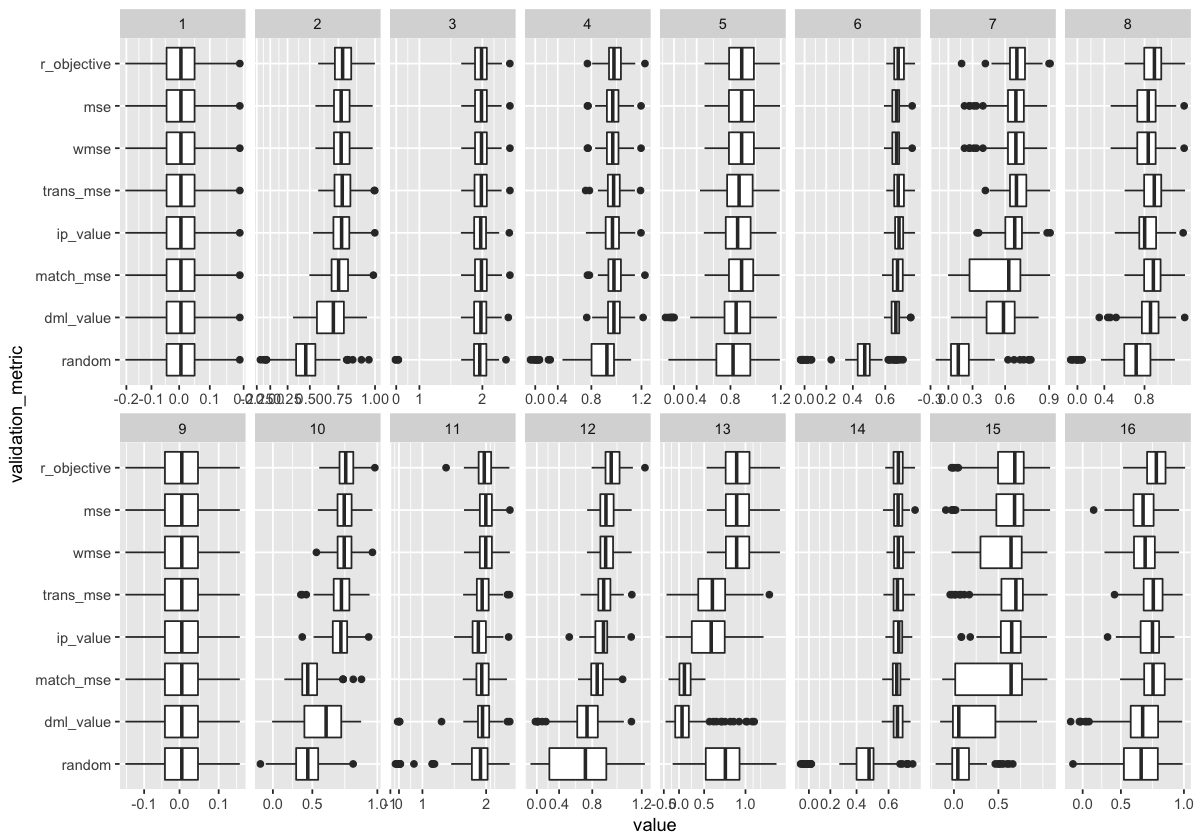

In [404]:
plotsize(10,7)

method_order = best_val_overall_mean %>% arrange(value_mean) %>% pull(validation_metric)

best_val %>%
    mutate(validation_metric = factor(validation_metric, levels=method_order)) %>%
ggplot(aes(x=validation_metric, y=value)) + 
    geom_boxplot() +
    coord_flip() +
    scale_y_continuous(trans=exp_trans()) + 
    facet_wrap(~dgp, scales="free_x", nrow=2)

Warning message:
: Transformation introduced infinite values in continuous y-axisWarning message:
: Removed 91 rows containing non-finite values (stat_boxplot).

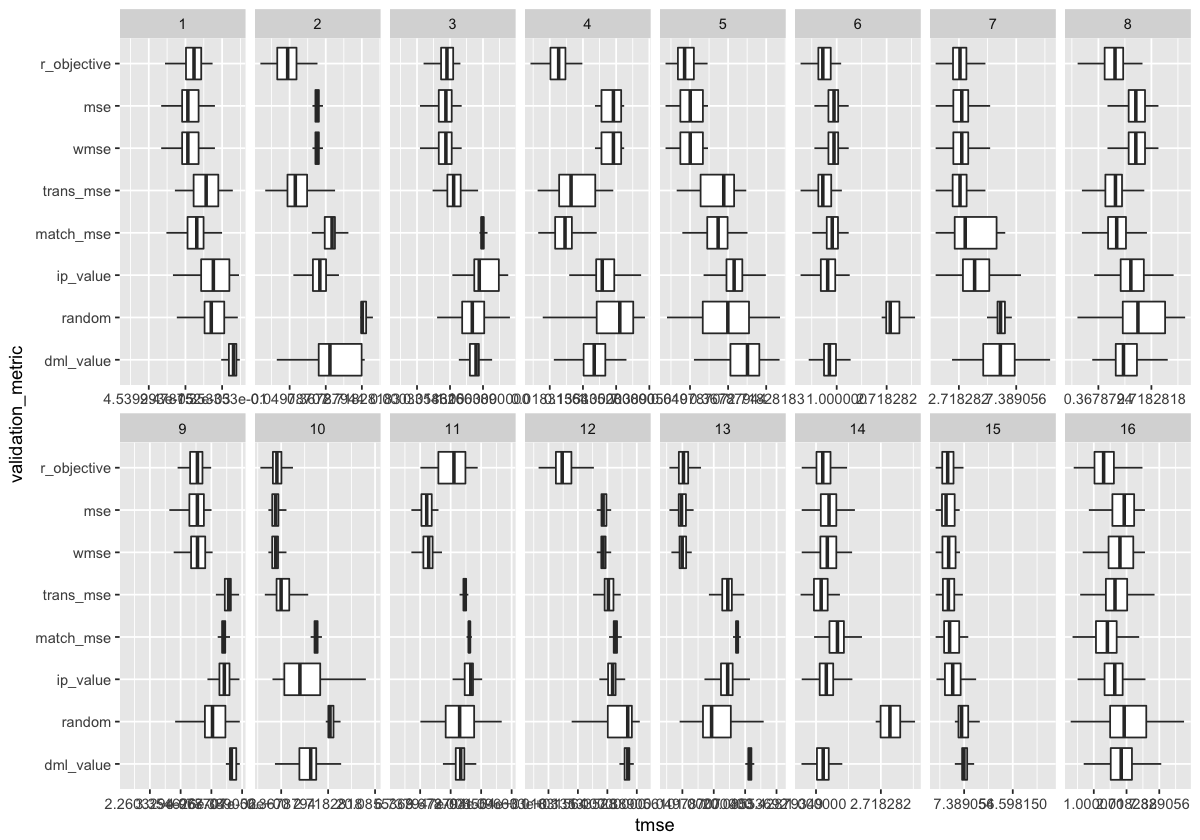

In [405]:
plotsize(10,7)

method_order = best_val_overall_mean %>% arrange(-tmse_mean) %>% pull(validation_metric)

best_val %>%
    mutate(validation_metric = factor(validation_metric, levels=method_order)) %>%
ggplot(aes(x=validation_metric, y=tmse)) + 
    geom_boxplot(outlier.shape=NA) +
    coord_flip() +
    scale_y_continuous(trans=log_trans()) + 
    facet_wrap(~dgp, scales="free_x", nrow=2)

In [13]:
head(best_val) %>% data.frame

model         tmse      value replicate dgp
1             R$gbm@281~3~0.1~3 4.979197e-01 0.01724959         1   1
2             S$gbm@481~3~0.1~3 2.491623e-01 0.01724959         1   1
3             R$gbm@361~3~0.1~3 6.067752e-01 0.01724959         1   1
4   T$glmnet@1~6.04964746441295 3.428665e-03 0.01724959         1   1
5 R$glmnet@0.5~1.82211880039051 8.492306e-07 0.01724959         1   1
6 T$glmnet@0.5~1.82211880039051 1.455760e-02 0.01724959         1   1
  validation_metric      estimate
1         dml_value -7.680717e-02
2          ip_value -1.190701e-02
3         match_mdc -1.820984e-02
4         match_mse  3.203617e+00
5               mse  9.890553e-01
6              qini -8.415188e+05

In [62]:
rel_diff = function(error, method, opt_method_name) {
    return(error - error[method==opt_method_name])
}

rel = function(error, method, opt_method_name) {
    return((error - error[method==opt_method_name])/(error[method=="oracle_selector_true_hte_error"] - error[method=="oracle"]))
}

In [63]:
no_prop_methods = c("random", "match_mse", "match_decision", "gain", "c_benefit", "qini", "value_auc", "est_te_strata", "prediction_error")

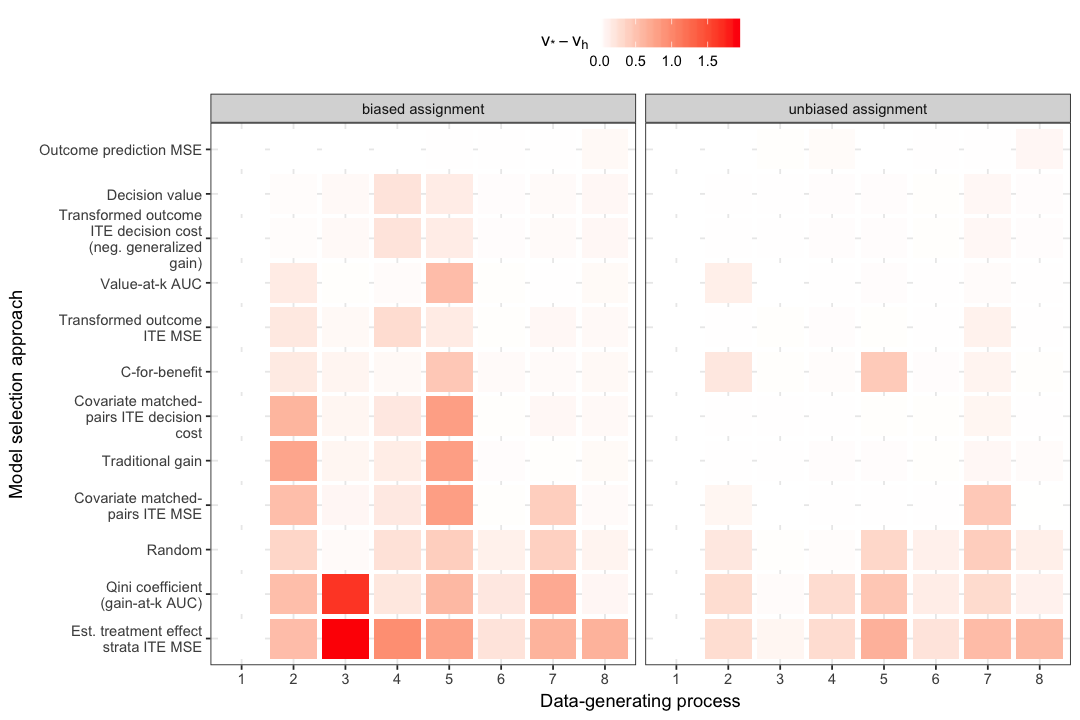

In [64]:
options(repr.plot.width=9, repr.plot.height=6)

rank_plot_data = results %>%
    mutate(assignment = ifelse(str_detect(DGP, "biased"), "biased assignment", "unbiased assignment")) %>%
    mutate(DGP = str_replace(DGP, "biased_", "")) %>%
    mutate(DGP = str_replace(DGP, "scenario_", "")) %>%
    group_by(DGP, assignment, n_folds, rep) %>% # within each simulation, get relative performance per method
    mutate(rel_true_hte_error = rel_diff(true_hte_error, selection_method, "oracle_selector_true_hte_error"),
           rel_true_value = rel_diff(true_value, selection_method, "oracle_selector_true_value")) %>%
    filter((str_detect(selection_method,"_est_prop") & (assignment=="biased assignment")) | # join _est_prop methods
           (!str_detect(selection_method,"_est_prop") & (assignment=="unbiased assignment")) |
           selection_method %in% no_prop_methods) %>%
    mutate(selection_method = str_replace(selection_method, "_est_prop", "")) %>%
    group_by(DGP, assignment, n_folds, selection_method) %>% # now average over reps within each method
    summarize(mean_value = mean(rel_true_value, na.rm=T), mean_tmse = mean(rel_true_hte_error, na.rm=T)) %>%
    ungroup() %>%
    filter(!str_detect(selection_method, "oracle")) %>%
    group_by(DGP, assignment, n_folds) %>%
    mutate(rank_value = rank(mean_value), rank_tmse = rank(mean_tmse)) %>%
    mutate(best_value = ifelse(rank_value==1, 1, NA), best_tmse=ifelse(rank_tmse==1, 1, NA)) %>%
    ungroup()

method_order = rank_plot_data %>%
    group_by(selection_method) %>%
    summarize(mean_rank = mean(mean_value)) %>%
    arrange(-mean_rank) %>%
    pull(selection_method)

rank_plot_data %>%
    filter(n_folds == 5) %>%
    mutate(selection_method = factor(selection_method, levels=method_order)) %>%
ggplot(aes(x=DGP, y=selection_method, fill=mean_value)) +
    geom_tile(size=1, height=0.9, width=0.9) +
#     scale_color_manual(guide=F, values=c(NA,"black")) + 
    scale_fill_gradient(name=expression(v[plain("*")] - v[h]), low="white", high="red") + 
    facet_grid(~assignment) +
    theme_bw() +
    scale_y_discrete(labels=method_renames) +
    xlab("Data-generating process") +
    ylab("Model selection approach") + 
    theme(legend.position="top")
ggsave("paper/figures/value-sim-comparison.png", units="in", width=9, height=6)

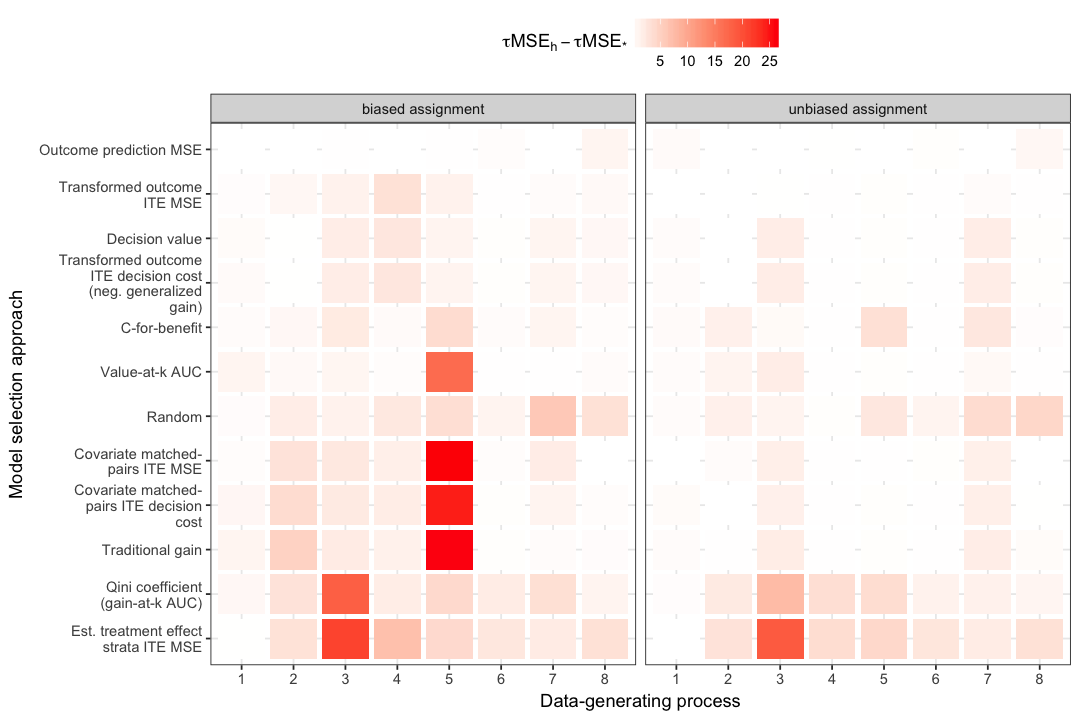

In [65]:
method_order = rank_plot_data %>%
    group_by(selection_method) %>%
    summarize(mean_rank = mean(mean_tmse)) %>%
    arrange(-mean_rank) %>%
    pull(selection_method)

rank_plot_data %>%
    filter(n_folds == 5) %>%
    mutate(selection_method = factor(selection_method, levels=method_order)) %>%
ggplot(aes(x=DGP, y=selection_method, fill=mean_tmse)) +
    geom_tile(size=1, height=0.9, width=0.9) +
#     geom_tile(aes(color=!is.na(best_tmse)), size=1, height=0.9, width=0.9) +
#     scale_color_manual(guide=F, values=c(NA,"black")) + 
    scale_fill_gradient(name=expression(tau * plain(MSE)[h] - tau * plain(MSE)[plain("*")]), low="white", high="red") + 
    facet_grid(~assignment) +
    theme_bw() +
    scale_y_discrete(labels=method_renames) +
    xlab("Data-generating process") +
    ylab("Model selection approach") + 
    theme(legend.position="top")
ggsave("paper/figures/tmse-sim-comparison.png", units="in", width=9, height=6)

# Junk... ?

In [205]:
rel_tmse = function(error, method) {
    return(error - error[method=="oracle_selector_true_hte_error"])
}

# rel_cost = function(error, method) {
#     return((error - error[method=="oracle"])/(error[method=="oracle_selector_true_value"] - error[method=="oracle"]))
# }

rel_cost = function(error, method) {
    return((error[method=="oracle_selector_true_value"] - error))
}

In [52]:
all_methods = results %>% pull(selection_method) %>% unique
method_types = list(
    framework_methods = c("trans_decision", "trans_mse", "match_decision", "match_mse", "trans_decision_est_prop", "trans_mse_est_prop", "random"),
    value_methods = c("gain", "trans_decision", "trans_decision_est_prop", "value", "value_est_prop", "match_decision", "random"),
    mse_methods = c("prediction_error", "trans_mse", "match_mse", "trans_mse_est_prop", "random"),
    ranking_methods = c("value_auc", "c_benefit", "qini", "random"),
    misc_methods = c("est_te_strata", "random"),
#     comparator_methods = c("oracle", "oracle_selector_true_hte_error", "oracle_selector_true_value", "random", "prediction_error"),
    winner_methods = c("trans_mse", "value", "prediction_error", "random")
)

In [53]:
rb_col = brewer.pal(length(method_types$framework_methods)-1,"Spectral")
bl_col = brewer.pal(length(method_types$value_methods)-1,"Blues")
pr_col = brewer.pal(length(method_types$ranking_methods)-1,"Purples")
br_col = c("saddlebrown", "sandybrown", "sienna2")

darken = function(color, factor=1.4){
    col = col2rgb(color)
    col = col/factor
    col = rgb(t(col), maxColorValue=255)
    col
}

In [55]:
method_fills = c(
    'random' = "grey",
    'match_mse'=rb_col[1],
    'trans_mse'=rb_col[2],
    'trans_mse_est_prop' = rb_col[5],
    'match_decision'=rb_col[3],
    'trans_decision'=rb_col[4],
    'trans_decision_est_prop' = rb_col[6],
    'gain'= bl_col[1],
    'value'= bl_col[2],
    'value_est_prop' = bl_col[3],
    'c_benefit' = pr_col[1],
    'qini'= pr_col[2], 
    'value_auc'= pr_col[3],
    'est_te_strata' = "pink",
    'prediction_error'= "wheat"
) 
# names(method_fills) = method_renames
method_colors = method_fills %>%
    map_chr(darken) %>%
    c
# names(method_colors) = method_renames

In [66]:
rel_results = results %>%
    mutate(assignment = ifelse(str_detect(DGP, "biased"), "biased assignment", "unbiased assignment")) %>%
    mutate(DGP = str_replace(DGP, "biased_", "")) %>%
    mutate(DGP = str_replace(DGP, "scenario_", "")) %>%
    group_by(DGP, n_folds, rep, n_train, n_test, assignment) %>%
    mutate(rel_true_hte_error = rel_tmse(true_hte_error, selection_method)) %>%
    mutate(rel_true_value = rel_cost(true_value, selection_method)) %>%
    filter((str_detect(selection_method,"_est_prop") & (assignment=="biased assignment")) |
           (!str_detect(selection_method,"_est_prop") & (assignment=="unbiased assignment")) |
           selection_method %in% no_prop_methods) %>%
    mutate(selection_method = str_replace(selection_method, "_est_prop", "")) %>%
    mutate(selection_method = factor(selection_method, levels=names(method_renames)))

In [68]:
full_error_plot = function(rel_results, fills, colors, methods) {
    rel_results %>%
        filter(selection_method %in% methods) %>%
#     ggplot(aes(x=as.factor(DGP), y=log10(rel_true_hte_error), 
    ggplot(aes(x=as.factor(DGP), y=true_hte_error, 
               fill=selection_method, color=selection_method)) +
        geom_boxplot() +
        scale_fill_manual(name="Selection method", values = fills, labels = method_renames) + 
        scale_color_manual(name="Selection method", values = colors, labels = method_renames) + 
        facet_grid(n_folds~assignment) +
        xlab("Data-generating process") + 
        ylab(expression(log(R* plain("-") *tau * plain(MSE)[h]))) +
        theme_bw() +
        theme(legend.key.height=unit(2, "cm")) + 
        theme(legend.key.width=unit(0.5, "cm"))
}

full_value_plot = function(rel_results, fills, colors, methods) {
    rel_results %>%
        filter(selection_method %in% methods) %>%
#     ggplot(aes(x=as.factor(DGP), y=log10(rel_true_value), 
    ggplot(aes(x=as.factor(DGP), y=true_value, 
               fill=selection_method, color=selection_method)) +
        geom_boxplot() +
        scale_fill_manual(name="Selection method", values = fills, labels = method_renames) + 
        scale_color_manual(name="Selection method", values = colors, labels = method_renames) + 
        facet_grid(n_folds~assignment) +
        xlab("Data-generating process") + 
        ylab(expression(log(R* plain("-") * plain(C)[h]))) +
        theme_bw() +
        theme(legend.key.height=unit(2, "cm")) + 
        theme(legend.key.width=unit(0.5, "cm"))
}

plot_util = function(rel_results, fills, colors, method_type_name, methods, w, h) {
    tMSE = full_error_plot(rel_results, fills, colors, methods)
    cost = full_value_plot(rel_results, fills, colors, methods)
    ggsave(str_c("paper/figures/", method_type_name, "-tMSE.png", sep=""), tMSE, units="in", width=w, height=h)
    ggsave(str_c("paper/figures/", method_type_name, "-cost.png", sep=""), cost, units="in", width=w, height=h)
    return(NULL)
}

In [69]:
method_types %>% iwalk(~plot_util(rel_results, method_fills, method_colors, .y, .x, 9, 6))

# Framework Methods

Warning message:
: Removed 430 rows containing non-finite values (stat_boxplot).

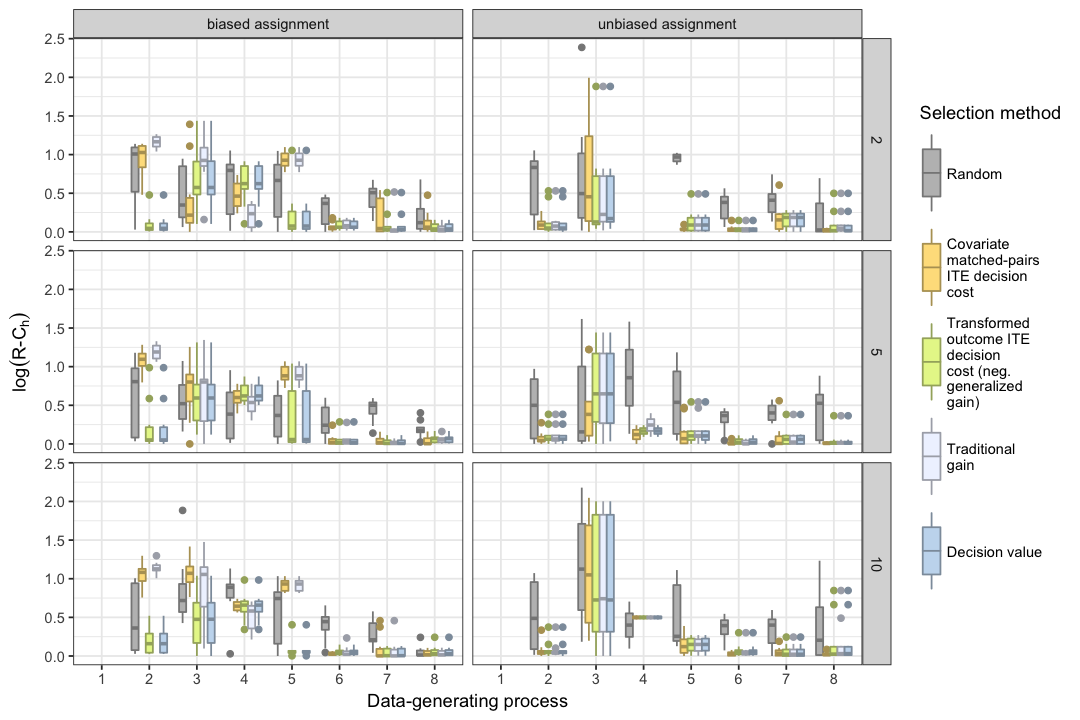

In [64]:
options(repr.plot.width=9, repr.plot.height=6)
full_value_plot(rel_results, method_fills, method_colors, c(method_types$value_methods))

In general, `Random` works decently because all of the models that are being selected from are reasonable.

`trans_mse` also seems to be doing well in terms of value. The decision-based metrics do well here, but again matching seems to hurt relative to weighting (probably because we're using the true .In terms of HTE error, `trans_mse` appears to work the best the most consistently. Matching and descision hurt a bit, trans and mse help. Number of folds doesn't matter that much. 

# Value Methods

These all do the exact same thing, as expected. Gain is a little different than the other two, but only in the biased assignment scenario because its estimating a group-wise propensity there whereas the other two have access to the true propensities.

# Ranking Methods

These all kinda suck. `value_auc` is the only one that consistently does better than random.

# Misc Methods

`random` often beats Rob's method, even with unbiased assignment

# Winner's Bracket

`trans_mse` and `prediction_error` are the winners here.

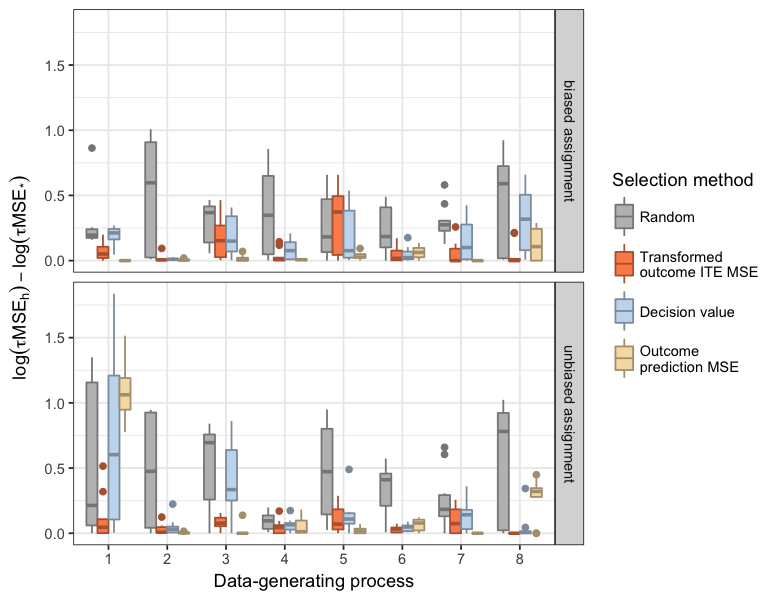

In [60]:
options(repr.plot.width=6.5, repr.plot.height=5)

rel_results %>%
    filter(selection_method %in% method_types$winner_methods) %>%
    filter(n_folds==5) %>%
ggplot(aes(x=as.factor(DGP), y=log10(rel_true_hte_error), 
           fill=selection_method, color=selection_method)) +
    geom_boxplot() +
    scale_fill_manual(name="Selection method", values = method_fills, labels = method_renames) + 
    scale_color_manual(name="Selection method", values = method_colors, labels = method_renames) + 
    facet_grid(assignment~.) +
    xlab("Data-generating process") + 
#     ylab("log(selected model error) - log(best model error)") +
    ylab(expression(log(tau * plain(MSE)[h]) - log(tau * plain(MSE)[plain("*")]))) +
    theme_bw() +
    theme(legend.key.height=unit(1, "cm")) + 

    theme(legend.key.width=unit(0.5, "cm"))

Warning message:
: Removed 556 rows containing non-finite values (stat_boxplot).

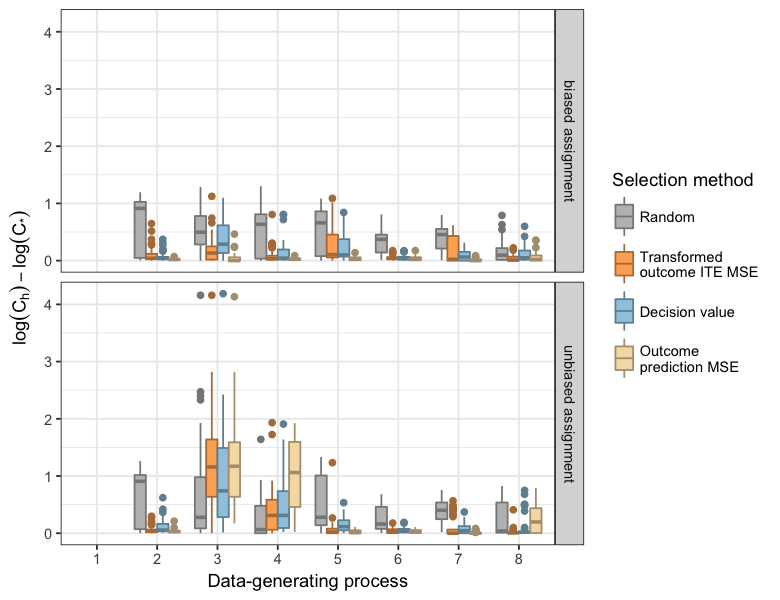

In [20]:
options(repr.plot.width=6.5, repr.plot.height=5)

rel_results %>%
    filter(selection_method %in% method_types$winner_methods) %>%
    filter(n_folds==5) %>%
    ggplot(aes(x=as.factor(DGP), y=log10(rel_true_value), 
           fill=selection_method, color=selection_method)) +
    geom_boxplot() +
    scale_fill_manual(name="Selection method", values = method_fills, labels = method_renames) + 
    scale_color_manual(name="Selection method", values = method_colors, labels = method_renames) + 
    facet_grid(assignment~.) +
    xlab("Data-generating process") + 
    ylab(expression(log(C[h]) - log(C[plain("*")]))) +
    theme_bw() +
    theme(legend.key.height=unit(1, "cm")) + 
    theme(legend.key.width=unit(0.5, "cm"))

This isn't quite right... need to look at all contrasts within the same rep, model, etc. Paired nonparametric test of means == wilcoxon signed rank test

In [26]:
rel_results %>%
    filter(selection_method %in% method_types$winner_methods) %>%
data.frame %>% head

model selection_method true_hte_error  true_value DGP
1              gbm~61~3~0.2~3 prediction_error     0.63438640  0.06108336   1
2 enet~0.5~0.0273237224472926           random     0.05092394  0.06108336   1
3               gbm~1~3~0.2~3        trans_mse     0.07106840  0.06108336   1
4             gbm~461~3~0.2~3            value     1.23557452  0.06108336   1
5             gbm~421~3~0.2~3 prediction_error     0.41401992 -0.85411914   2
6   enet~0.5~0.67032004603564           random     2.70946075 -0.59947746   2
  n_train n_test n_folds rep          assignment rel_true_hte_error
1    1000   2000       2   1 unbiased assignment          12.520881
2    1000   2000       2   1 unbiased assignment           1.005086
3    1000   2000       2   1 unbiased assignment           1.402677
4    1000   2000       2   1 unbiased assignment          24.386529
5    1000   2000       2   1 unbiased assignment           1.022920
6    1000   2000       2   1 unbiased assignment           6.694270
  rel_true_value
1            NaN
2            NaN
3            NaN
4            NaN
5       1.056738
6       4.851064

In [71]:
test_results = rel_results %>%
    filter(selection_method %in% method_types$winner_methods) %>%
    select(DGP, n_train, n_test, n_folds, rep, assignment, selection_method, true_value) %>%
    spread(selection_method, true_value) 

In [72]:
tail(test_results %>% data.frame)

DGP n_train n_test n_folds rep          assignment     random  trans_mse
475   8    1000   2000      10   8   biased assignment -0.6276813 -0.6298665
476   8    1000   2000      10   8 unbiased assignment -0.3849071 -0.7944426
477   8    1000   2000      10   9   biased assignment -0.4439474 -0.6470274
478   8    1000   2000      10   9 unbiased assignment -0.6335139 -0.9147108
479   8    1000   2000      10  10   biased assignment -0.7965601 -0.7966523
480   8    1000   2000      10  10 unbiased assignment -0.7359168 -0.7359168
         value prediction_error
475 -0.6299027       -0.6298665
476 -0.8007619       -0.5876846
477 -0.6435136       -0.5205092
478 -0.8860616       -0.8860616
479 -0.7951882       -0.7966523
480 -0.6691224       -0.6691224

In [59]:
?t.test

t.test                  package:stats                  R Documentation

_S_t_u_d_e_n_t'_s _t-_T_e_s_t

_D_e_s_c_r_i_p_t_i_o_n:

     Performs one and two sample t-tests on vectors of data.

_U_s_a_g_e:

     t.test(x, ...)
     
     ## Default S3 method:
     t.test(x, y = NULL,
            alternative = c("two.sided", "less", "greater"),
            mu = 0, paired = FALSE, var.equal = FALSE,
            conf.level = 0.95, ...)
     
     ## S3 method for class 'formula'
     t.test(formula, data, subset, na.action, ...)
     
_A_r_g_u_m_e_n_t_s:

       x: a (non-empty) numeric vector of data values.

       y: an optional (non-empty) numeric vector of data values.

alternative: a character string specifying the alternative hypothesis,
          must be one of ‘"two.sided"’ (default), ‘"greater"’ or
          ‘"less"’.  You can specify just the initial letter.

      mu: a number indicating the true value of the mean (or difference
          in means if you are performing a two sample test).

  paired: a logical indicating whether you want a paired t-test.

var.equal: a logical variable indicating whether to treat the two
          variances as being equal. If ‘TRUE’ then the pooled variance
          is used to estimate the variance otherwise the Welch (or
          Satterthwaite) approximation to the degrees of freedom is
          used.

conf.level: confidence level of the interval.

 formula: a formula of the form ‘lhs ~ rhs’ where ‘lhs’ is a numeric
          variable giving the data values and ‘rhs’ a factor with two
          levels giving the corresponding groups.

    data: an optional matrix or data frame (or similar: see
          ‘model.frame’) containing the variables in the formula
          ‘formula’.  By default the variables are taken from
          ‘environment(formula)’.

  subset: an optional vector specifying a subset of observations to be
          used.

na.action: a function which indicates what should happen when the data
          contain ‘NA’s.  Defaults to ‘getOption("na.action")’.

     ...: further arguments to be passed to or from methods.

_D_e_t_a_i_l_s:

     The formula interface is only applicable for the 2-sample tests.

     ‘alternative = "greater"’ is the alternative that ‘x’ has a larger
     mean than ‘y’.

     If ‘paired’ is ‘TRUE’ then both ‘x’ and ‘y’ must be specified and
     they must be the same length.  Missing values are silently removed
     (in pairs if ‘paired’ is ‘TRUE’).  If ‘var.equal’ is ‘TRUE’ then
     the pooled estimate of the variance is used.  By default, if
     ‘var.equal’ is ‘FALSE’ then the variance is estimated separately
     for both groups and the Welch modification to the degrees of
     freedom is used.

     If the input data are effectively constant (compared to the larger
     of the two means) an error is generated.

_V_a_l_u_e:

     A list with class ‘"htest"’ containing the following components:

statistic: the value of the t-statistic.

parameter: the degrees of freedom for the t-statistic.

 p.value: the p-value for the test.

conf.int: a confidence interval for the mean appropriate to the
          specified alternative hypothesis.

estimate: the estimated mean or difference in means depending on
          whether it was a one-sample test or a two-sample test.

null.value: the specified hypothesized value of the mean or mean
          difference depending on whether it was a one-sample test or a
          two-sample test.

alternative: a character string describing the alternative hypothesis.

  method: a character string indicating what type of t-test was
          performed.

data.name: a character string giving the name(s) of the data.

_S_e_e _A_l_s_o:

     ‘prop.test’

_E_x_a_m_p_l_e_s:

     require(graphics)
     
     t.test(1:10, y = c(7:20))      # P = .00001855
     t.test(1:10, y = c(7:20, 200)) # P = .1245    -- NOT significant anymore
     
     ## Classical exam

In [61]:
test_results %$%
#     filter(!is.na(trans_mse) & !is.na(prediction_error)) %$%
    t.test(prediction_error, trans_mse, paired=TRUE)
test_results %>% 
    mutate(diff = trans_mse-prediction_error) %>%
    pull(diff) %>%
    mean(na.rm=T)

ERROR: Error in if (stderr < 10 * .Machine$double.eps * abs(mx)) stop("data are essentially constant"): missing value where TRUE/FALSE needed


[1] 0.2242633